# Mini-Project: **Food Desert: Accessibility by Average and Wheelchair Users**

Welcome to our mini-project on Food Desert: Accessibility by Average and Wheelchair Users. As urban areas grapple with the challenges of food deserts and ensuring equitable access to essential services, understanding the transit experiences of different user groups becomes important. This mini-project dives deep into transit accessibility, particularly on the experiences of both average and wheelchair users. You will be guided through the steps of visualizing origin-destination data, aggregating transit metrics, and evaluating the time spent by travelers in various transit modes. Together, we'll uncover insights and explore the implications of these findings for urban planning and transit policy.


## Copyright and License Information

© September 2023 Huiying ("Fizzy") Fan, Reid Passmore, Randall Guensler, Georgia Institute of Technology. All rights reserved.

This material is for personal use and is protected by law. Reproduction or distribution without explicit permission is prohibited.

## Citations

The development of this project is based on the following project. Please cite them properly:

- **Passmore, R., Fan, H., & Guensler, R.** (2023) - *Shortest Path Routing Lab. CEE/CP6702 Urban Transportation Lab [lecture]. Georgia Institute of Technology*

- **Fan, H., Guin, A., & Guensler, R.** (2023) - *Using Multi-Modal Path-Specific Transit Trips in Transportation Social Sustainability Analysis: Case Study in Atlanta, GA*. Research Report from the National Center for Sustainable Transportation. August 2023.

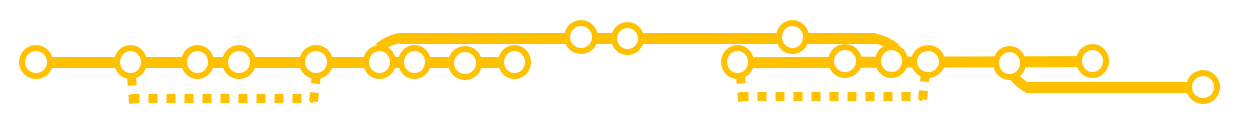


## Table of Contents
- **Visualizing Origins and Destinations**
- **Data Aggregation and Transformation**
- **Average Time Spent by Each Traveler in Each Mode**
- **Spatial Visualization of Riding, Walking, and Combined Metrics**
- **Adjusting Walking Time for Wheelchair Users**
- **Comparative Visualization for Average and Wheelchair Users**
- **Final Thoughts**

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

In [ ]:
O_D_PATH = './project_food/o_d_info.csv'
TRIP_PATH = './data/sample/trips.csv'
INT_TRAJ_PATH = './data/postproc/traj_integrated'

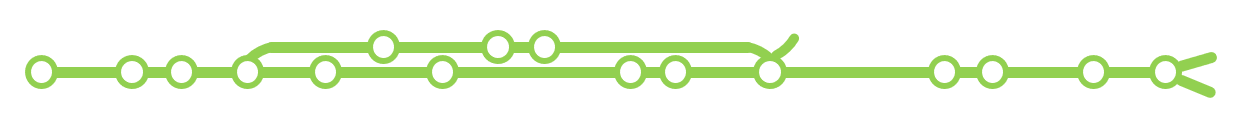

## 1. **Visualizing Origins and Destinations**

The trips data that has been given to you are actually a series of households and a series of grocery stops. The trips are from every household to every grocery location. In this section, we will have a better understanding of this data. 


In [ ]:
o_d_info = pd.read_csv(O_D_PATH)
trips = pd.read_csv(TRIP_PATH)

In [ ]:
o_d_info.head()

In [ ]:
df_trips = o_d_info.merge(trips, how='left', on='trip_id')
df_ori = df_trips.groupby(['ori'])[['ori_lat', 'ori_lon']].agg('first').reset_index()
df_dest = df_trips.groupby(['dest'])[['dest_lat', 'dest_lon']].agg('first').reset_index()

In [ ]:
# Convert to GeoDataFrame
gdf_dest = gpd.GeoDataFrame(df_dest, geometry=gpd.points_from_xy(df_dest.dest_lon, df_dest.dest_lat), crs="EPSG:4326")
gdf_ori = gpd.GeoDataFrame(df_ori, geometry=gpd.points_from_xy(df_ori.ori_lon, df_ori.ori_lat), crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Convert CRS for plotting with contextily
gdf_dest = gdf_dest.to_crs(epsg=3857)
gdf_ori = gdf_ori.to_crs(epsg=3857)

gdf_dest.plot(ax=ax, markersize=50, color='red', label='Destinations')
gdf_ori.plot(ax=ax, markersize=50, color='blue', label='Origins')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Add legend and title
ax.legend()
ax.set_title("Origins and Destinations")
ax.axis('off')
plt.show()

The map above shows the temperature distribution in our study area. Areas with warmer colors indicate higher temperatures.


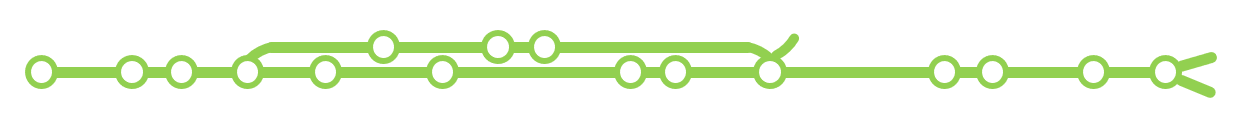

## 2. **Data Aggregation and Transformation**
Now, we will aggregate our data and transform it to get a summarized view. This involves reading multiple files, aggregating travel times, and categorizing different modes of the transit trip.

In [ ]:
all_files = [f for f in os.listdir(INT_TRAJ_PATH) if f.endswith('.csv')]
dfs = []

for file in all_files:
    trip_id = file.split('.')[0]  # Extract trip_id from filename
    df = pd.read_csv(os.path.join(INT_TRAJ_PATH, file))
    df.loc[df['mode'].isin(['walk_ingress','walk_egress']), 'mode'] = 'walking'
    df.loc[df['mode']=='correspondence', 'mode'] = 'boarding/alighting'
    
    # For correspondence mode, count the number of occurrences
    correspondence_count = df[df['mode'] == 'boarding/alighting'].shape[0]
    
    # For other modes, aggregate the sum of tt_seconds
    summary = df[df['mode'] != 'boarding/alighting'].groupby('mode')['tt_seconds'].sum()
    summary = summary/60 # transform to minutes
    
    # Add the correspondence count to the summary
    summary['boarding/alighting'] = correspondence_count
    
    summary.name = trip_id
    dfs.append(summary)

# Concatenate all the DataFrames
summary_df = pd.concat(dfs, axis=1).transpose()
o_d_info.set_index('trip_id', inplace=True)
summary_df['ori'] = o_d_info['ori']
summary_df['dest'] = o_d_info['dest']

In [ ]:
summary_df

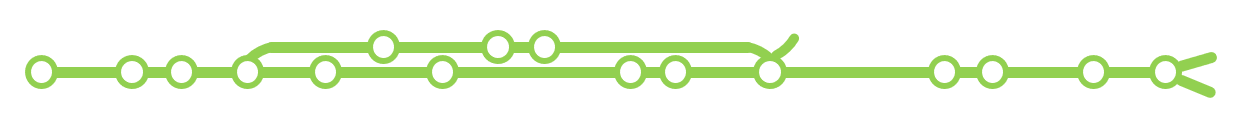

## 3. **Average Time Spent by Each Traveler in Each Mode**
With our data aggregated, let's visualize the average time each traveler spends in different modes of the transit trip. This will give us insights into the most time-consuming modes for each traveler
.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the correspondence column
df1 = summary_df.copy()
df1 = df1.drop(columns=['boarding/alighting'])

# Group by the ori column and compute the mean for each mode
grouped = df1.groupby('ori').mean()

# Reset the index for visualization
grouped = grouped.reset_index()

# Melt the dataframe for visualization
melted = pd.melt(grouped, id_vars=['ori'], value_vars=grouped.columns[1:], 
                 var_name='mode', value_name='average_time')

# Visualize using a bar chart
plt.figure(figsize=(15, 7))
sns.barplot(data=melted, x='ori', y='average_time', hue='mode')
plt.title('Average Time Spent by Each Traveler in Each Mode')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Traveler')
plt.legend(title='Mode')
plt.show()

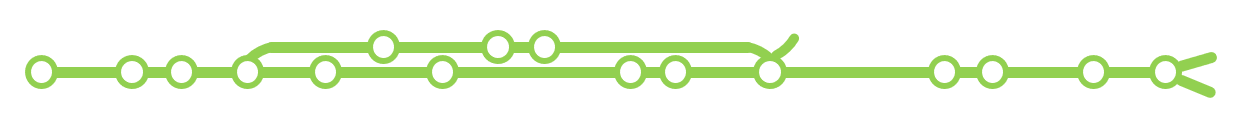

## 4. **Spatial Visualization of Riding, Walking, and Combined Metrics**
In this section, we will create spatial visualizations to understand the distribution of riding, walking, and their combined metrics across different origins.

In [ ]:
df2 = summary_df.copy()
df2 = df2[['ori','riding','walking']]
df2 = df2.groupby('ori').mean()
df2['ride+walk'] = df2['walking'] + df2['riding']
df2.reset_index(inplace=True)
df2 = df2.merge(origin, how='left', on='ori')

In [ ]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.ori_lon, df2.ori_lat), crs="EPSG:4326")

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

metrics = ['riding', 'walking', 'ride+walk']
titles = ['Riding', 'Walking', 'Ride + Walk']

for ax, metric, title in zip(axes, metrics, titles):
    gdf = gdf.to_crs(epsg=3857)
    gdf.plot(ax=ax, markersize=gdf[metric]*10, column=metric, legend=True, cmap='viridis_r')
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

What did you find about locations and travel time?

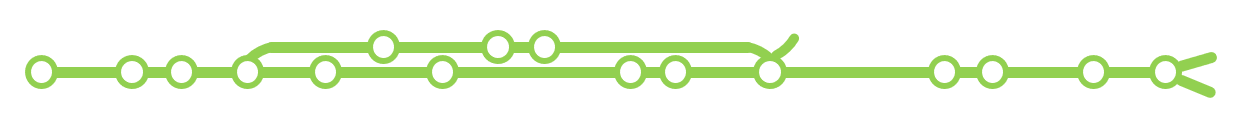

## 5. **Adjusting Walking Time for Wheelchair Users**
Wheelchair users might have different walking times compared to average users. Besides, statistics show that wheelchair users use an average of 2.75 minutes to board or alight a bus. In this section, we will account for these factors, dive into this difference and visualize the results.

In [ ]:
df3 = summary_df.copy()
df3['walking'] = df3['walking']*2.5/1.0
df3['boarding/alighting'] = df3['boarding/alighting']*2.75

In [ ]:
# Group by the ori column and compute the mean for each mode
grouped = df3.groupby('ori').mean()

# Reset the index for visualization
grouped = grouped.reset_index()

# Melt the dataframe for visualization
melted = pd.melt(grouped, id_vars=['ori'], value_vars=grouped.columns[1:], 
                 var_name='mode', value_name='average_time')

# Visualize using a bar chart
plt.figure(figsize=(15, 7))
sns.barplot(data=melted, x='ori', y='average_time', hue='mode')
plt.title('Average Time Spent by Each Traveler in Each Mode')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Traveler')
plt.legend(title='Mode')
plt.show()

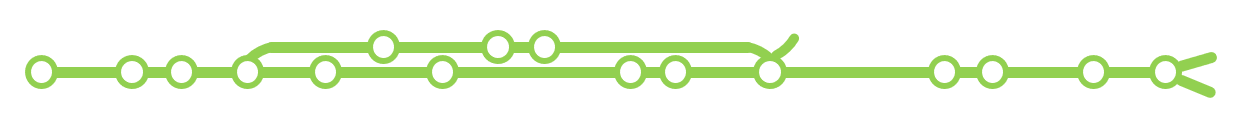

## 6. **Comparative Visualization for Average and Wheelchair Users**
Finally, we will create a comparative visualization to understand the differences in travel times between average and wheelchair users. This will help us identify potential areas of improvement in our transit system for wheelchair users.

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# df1 = df1.groupby('ori').mean().reset_index()
# df3 = df3.groupby('ori').mean().reset_index()

bar_width = 0.35
index = range(len(df1))

# Plot data from df1
bars1 = ax.bar(index, df1['riding'], bar_width, label='Riding (average user)', color='b', alpha=0.6)
bars2 = ax.bar(index, df1['waiting'], bar_width, bottom=df1['riding'], label='Waiting (average user)', color='r', alpha=0.6)
bars3 = ax.bar(index, df1['walking'], bar_width, bottom=df1['riding'] + df1['waiting'], label='Walking (average user)', color='g', alpha=0.6)

# Plot data from df2 with shifted index for grouped bars
bars4 = ax.bar([i + bar_width for i in index], df3['riding'], bar_width, label='Riding (wheelchair user)', color='b', alpha=0.3)
bars5 = ax.bar([i + bar_width for i in index], df3['waiting'], bar_width, 
               bottom=df3['riding'], label='Waiting (wheelchair user)', color='r', alpha=0.3)
bars6 = ax.bar([i + bar_width for i in index], df3['walking'], bar_width, 
               bottom=df3['riding'] + df3['waiting'], label='Walking (wheelchair user)', color='g', alpha=0.3)
bars6 = ax.bar([i + bar_width for i in index], df3['boarding/alighting'], 
               bar_width, 
               bottom=df3['walking'] + df3['riding'] + df3['waiting'], 
               label='Boarding/alighting (wheelchair user)', color='y', alpha=0.3)

# Labeling and formatting
ax.set_xlabel('Traveler')
ax.set_ylabel('Time')
ax.set_title('Comparison of Modes from Two DataFrames')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(df1['ori'])
ax.legend()

plt.tight_layout()
plt.show()


The chart above shows the time spent in each heat exposure category, broken down by mode of transit.



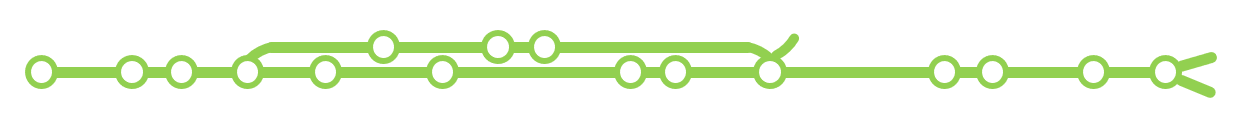

## 7. **Final Thoughts**

If you will present your findings to ARC, what would you suggest?
* What're the biggest challenges with transit riding? How would you suggest to mitigate them?
* Do wheelchair users face the same challenges as average users? How would you suggest to enhance their travel condition?
* What would you suggest on infrastructure planning in general?

After the analysis, let's tie it back to TransitSim 4.0. Back to the questions raised at the beginning of the lecture. Do you have different answers to the questions? 
* How is transit modeling different from other types of networks? What will happen if this analysis is to be done with a spatial graph?
* Is travel time enough for us to know all we need about a transit trip?
* What's the advantage of having second-by-second trajectory?